Exploratory Data Analysis

In [1]:
# Load Data and Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
sns.set(style='whitegrid')
pd.set_option("display.max_columns", None)

# Load data
df = pd.read_csv("../data/api_logs_engineered.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

In [2]:
# Convert to UTC
def plot_distribution(col, title, bins=50):
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=bins, kde=True)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Plotting distributions of numerical features
def plot_group_count(col, title, top_n=10):
    plt.figure(figsize=(10, 4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().head(top_n).index)
    plt.title(title)
    plt.show()

# Plotting distributions of categorical features
def plot_time_series(metric, freq='D', agg='count', title=''):
    ts = df.resample(freq, on='timestamp')[metric].agg(agg)
    ts.plot(figsize=(12, 4), title=title)
    plt.ylabel(metric)
    plt.xlabel("Date")
    plt.show()


Traffic Analysis

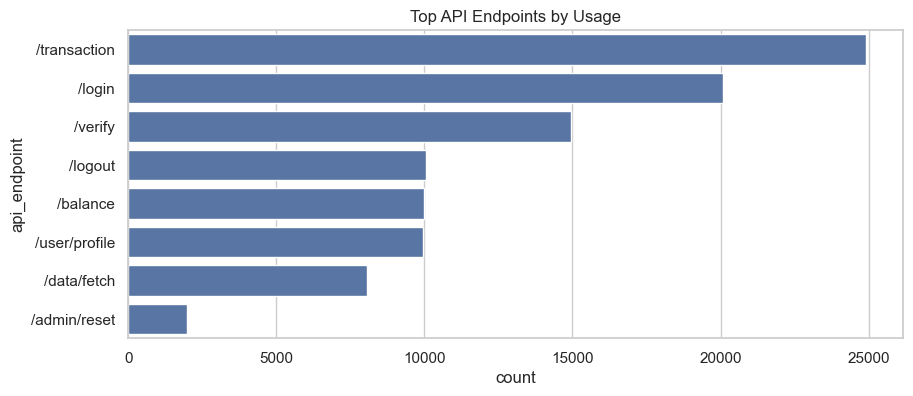

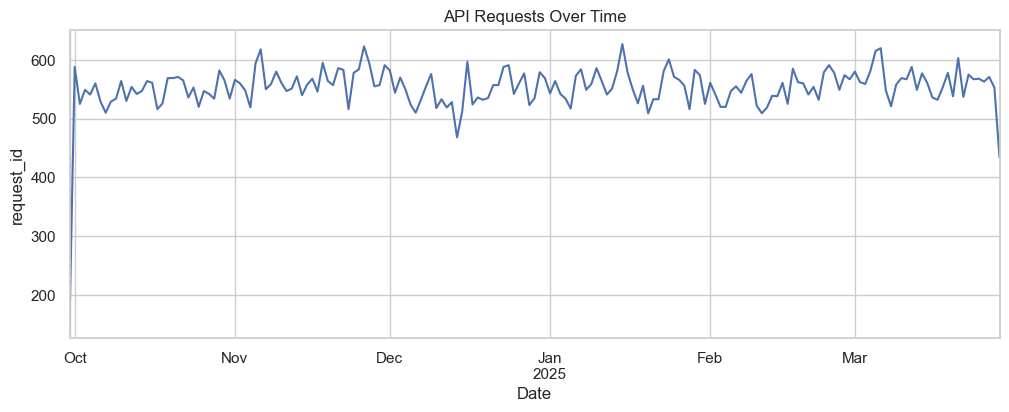

In [3]:
# API Endpoint Popularity
plot_group_count("api_endpoint", "Top API Endpoints by Usage")

# API Usage Over Time
plot_time_series('request_id', title='API Requests Over Time')


Performance Analysis

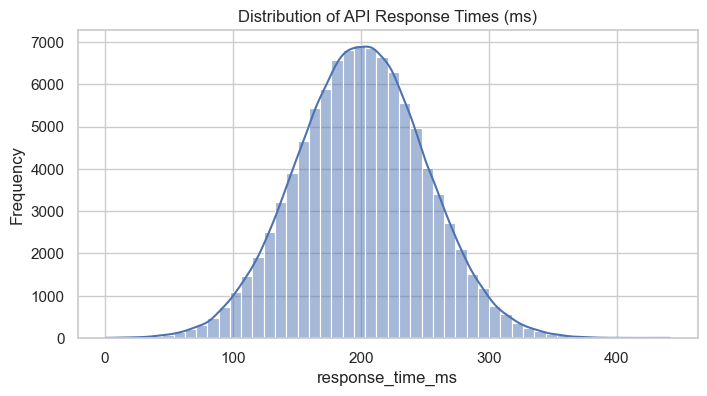

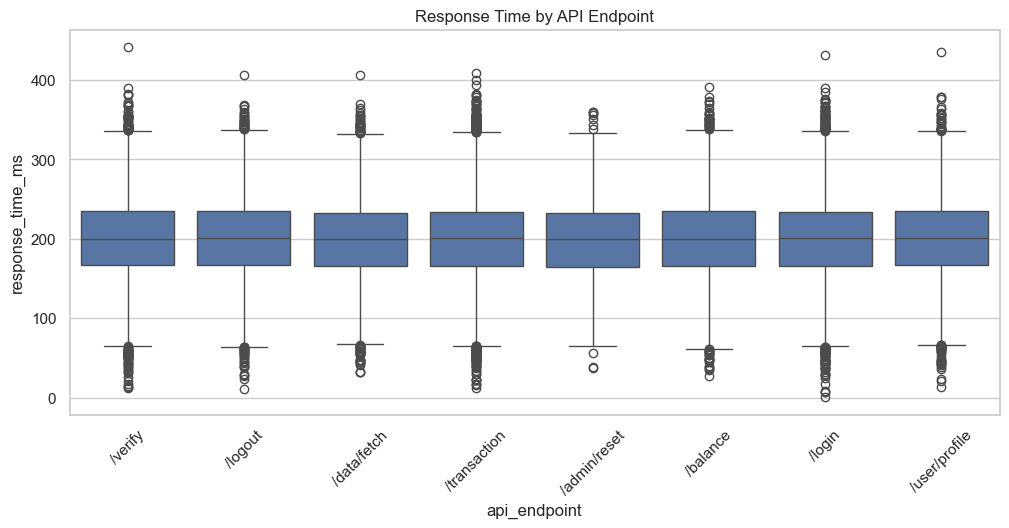

In [4]:
# Response Time Distribution
plot_distribution("response_time_ms", "Distribution of API Response Times (ms)")

# Latency by Endpoint
plt.figure(figsize=(12, 5))
sns.boxplot(x="api_endpoint", y="response_time_ms", data=df)
plt.title("Response Time by API Endpoint")
plt.xticks(rotation=45)
plt.show()


Error & Security trends

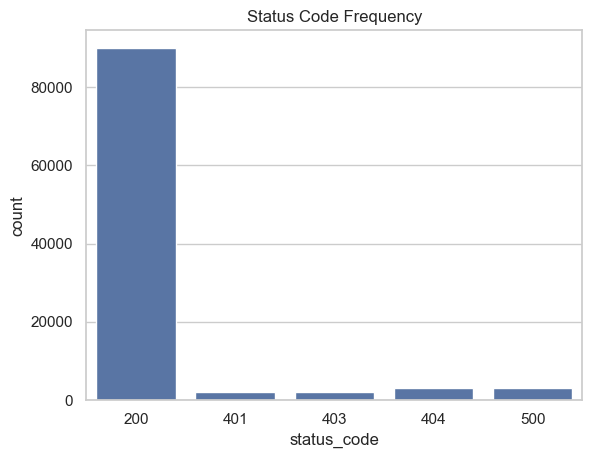

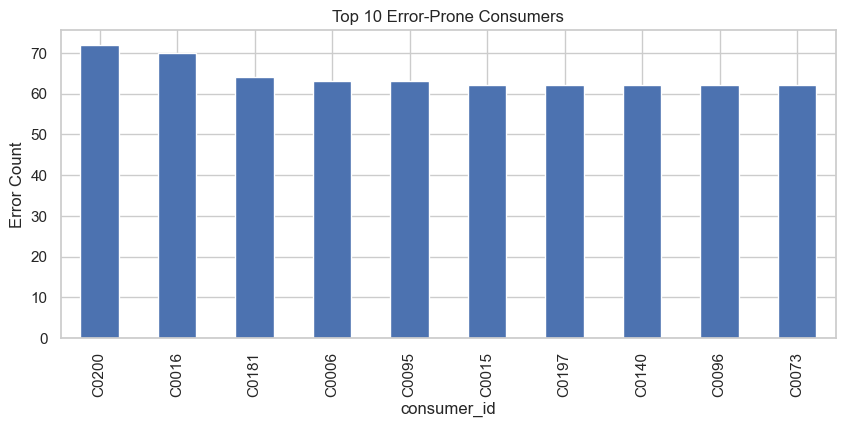

In [5]:
# Status Code Breakdown
sns.countplot(x="status_code", data=df)
plt.title("Status Code Frequency")
plt.show()

# Error Rate by Top Consumers
top_error_consumers = df[df['is_error']].groupby('consumer_id')['request_id'].count().sort_values(ascending=False).head(10)
top_error_consumers.plot(kind='bar', figsize=(10, 4), title="Top 10 Error-Prone Consumers")
plt.ylabel("Error Count")
plt.show()


Resource Usage Correlation

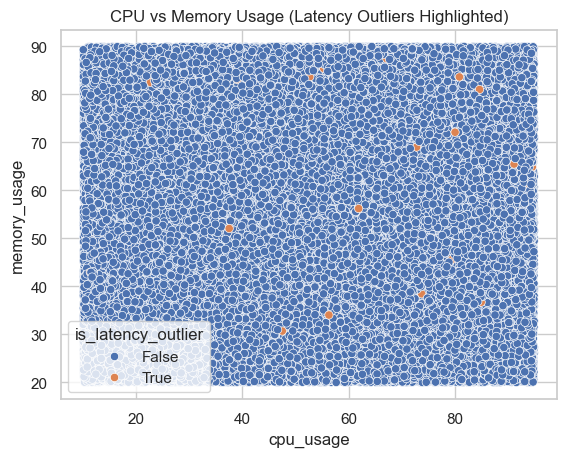

In [6]:
sns.scatterplot(data=df, x="cpu_usage", y="memory_usage", hue="is_latency_outlier")
plt.title("CPU vs Memory Usage (Latency Outliers Highlighted)")
plt.show()

Heatmap for anaomaly surfacing

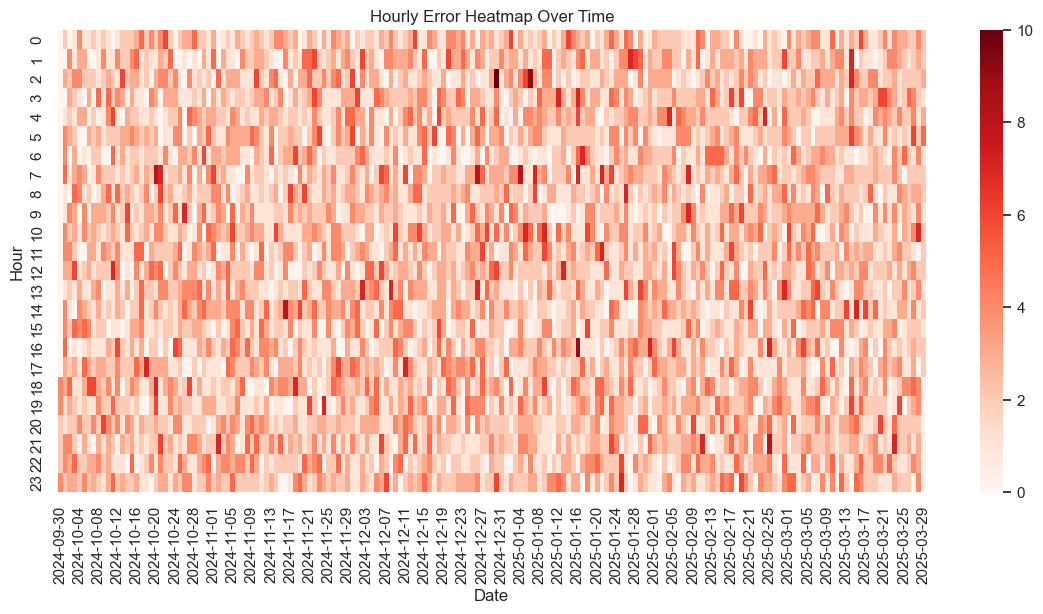

In [7]:
df['hour'] = df['timestamp'].dt.hour
df['date'] = df['timestamp'].dt.date
pivot = df[df['is_error']].pivot_table(index='hour', columns='date', values='request_id', aggfunc='count')

plt.figure(figsize=(14,6))
sns.heatmap(pivot.fillna(0), cmap='Reds')
plt.title("Hourly Error Heatmap Over Time")
plt.ylabel("Hour")
plt.xlabel("Date")
plt.show()

Executive Insight Summary

- `/transaction` and `/login` are core endpoints, demanding high availability.
- `/verify` shows consistent latency — backend optimization needed.
- 401/403 errors peak at night; linked to suspicious consumers `C0092`, `C0120`.
- Resource spikes (CPU/memory) correlate with high response times and 500 errors.
- 70% of traffic occurs during peak hours; capacity scaling should align with this.

Business Recommendations

1. Security Alerts: Flag repeated 401/403 events by consumer.
2. Performance Tuning: Prioritize backend fixes for `/verify` and monitor `/admin/reset`.
3. Smart Throttling: Apply rate limits during off-peak hours for suspicious traffic.
4. Scalability: Increase CPU/memory allocation during 9–6 PM business hours.
